In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy

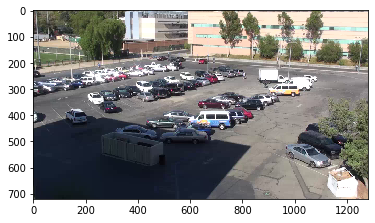

In [39]:
# load video into a generator of images
def v2i(filename, scale=1):
    cap = cv2.VideoCapture(filename)
    while(True):
        ret, frame = cap.read()
        if ret: 
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (frame.shape[1] // scale, frame.shape[0] // scale))
            yield frame
        else: break

# read video
path = 'videos/VIRAT_S_010111_08_000920_000954.mp4'
scale = 1
video = v2i(path, scale)
frame0 = next(video)
img=frame0.copy()
plt.imshow(frame0, cmap='gray')

In [40]:
# load the homographies
def load_homography(fname):
    """ Load a homography from a text file """
    return np.loadtxt(fname, delimiter=',')
    
path = 'homographies/VIRAT_0101_homography_img2world.txt'
H = load_homography('homographies/VIRAT_0101_homography_img2world.txt')

print(H)

[[-2.9320106e-04  1.2073065e-03 -5.9184241e-01]
 [ 5.0597447e-04  9.6643864e-04 -8.0604973e-01]
 [ 7.7224635e-08 -4.5847150e-05  2.0273329e-03]]


# Interface for User Selections

In [41]:
def slope(p1, p2):
    """ Calculate the slope. Returns None if undefined """
    x1, y1 = p1
    x2, y2 = p2
    if x2 != x1:
        return((y2-y1)/(x2-x1))
    else:
        return None
    
def draw_line(image, p1, p2, color, thickness):
    """ Ensures that line stretches across the entire image """
    x1, y1 = p1
    x2, y2 = p2
    m = slope(p1,p2)
    h, w, c = image.shape

    if m != None:
        # extend the line to x == 0 and x == width, then get y's 
        px=0
        py=-(x1-0)*m+y1
        
        ##ending point
        qx=w
        qy=-(x2-w)*m+y2
    else:
        # if slope == 0 (None), draw a line with x = x1 and y = 0 and y = height
        px, py = x1, 0
        qx, qy = x1,h
        
    cv2.line(image, (int(px), int(py)), (int(qx), int(qy)), color, thickness)
    return image

def draw_gridlines(img, H, xrange, yrange, step=5, **kwargs):
    """ Handle the drawing of the gridlines from the homography """
    
    # get meshgrid
    height, width, channels = img.shape
    x = np.arange(xrange[0], xrange[1], step=step)
    y = np.arange(yrange[0], yrange[1], step=step)
    xx, yy = np.meshgrid(x, y)
    
    # deform points from world coords to image coords
    H_inv = np.linalg.inv(H)
    irange, jrange = yy.shape
    new_x = np.zeros(xx.shape)
    new_y = np.zeros(yy.shape)
    
    # find new coords
    for i in range(irange):
        for j in range(jrange):
            real_coord = [xx[i,j], yy[i,j], 1]
            img_coord = H_inv @ real_coord
            img_coord = img_coord / img_coord[2]
            new_x[i,j] = img_coord[0]
            new_y[i,j] = img_coord[1]
    
    # draw vertlines
    line_color = (0, 255, 0)
    line_thickness = 1
    for j in range(jrange):
        # note that j == x
        p1 = (np.int(new_x[0, j]), np.int(new_y[0, j]))  # top point
        p2 = (np.int(new_x[-1, j]), np.int(new_y[-1, j]))  # bottom point
        #img = cv2.line(img, p1, p2, line_color, line_thickness)
        img = draw_line(img, p1, p2, line_color, line_thickness)
        
    for i in range(irange):
        # note that j == x
        p1 = (np.int(new_x[i, 0]), np.int(new_y[i, 0]))  # top point
        p2 = (np.int(new_x[i, -1]), np.int(new_y[i, -1]))  # bottom point
        #img = cv2.line(img, p1, p2, line_color, line_thickness)
        img = draw_line(img, p1, p2, line_color, line_thickness)
        
    return img

def adjust_point(pt, point_list):
    """ 
    Helper function to modify the location of points. Modifies point_list in place.
    Expects pt = (x,y), point_list = [(x,y), (x,y)...]
    """
    closest_dist = 100000000  # lol if you're working with an image this large
    tup = (0, 0)  # temp point
    tup_idx = 0   # temp index
    
    for idx, el in enumerate(point_list):
        x1, y1 = el
        x2, y2 = pt
        dist = np.sqrt( (x1-x2)**2 + (y1-y2)**2 )
        if dist < closest_dist:
            closest_dist = dist
            tup = (x2, y2)
            tup_idx = idx
            
    # modify list in place
    point_list[tup_idx] = tup

def point_handler(event, x, y, flags, param):
    """ Handler for the doubleclicking to select points """
    if event == cv2.EVENT_LBUTTONDBLCLK:
        # if we don't have all of our points yet, add it to the list
        if len(param[0]) < 4:
            param[0].append((x,y))
            
        # if we already have all of our points, make sure to change closest
        else:
            adjust_point((x,y), param[0])


def draw_points(new_img, point_list):
    """ Handle the drawing of points and the lines between them """
    
    # Draw lines between points if possible
    line_color = (0, 255, 0)
    line_thickness = 1
    for i in range(len(point_list)):
        if i >= 1:
            p1 = point_list[i-1]
            p2 = point_list[i]
            new_img = cv2.line(new_img, p1, p2, line_color, line_thickness)
            
        # complete the square
        if i == 3:
            p1 = point_list[0]
            p2 = point_list[3]
            new_img = cv2.line(new_img, p1, p2, line_color, line_thickness)            
    
    # Draw each point
    point_color = (0, 0, 255)
    for pt in point_list:
        new_img = cv2.circle(new_img, pt, 2, point_color, 2)
         
    return new_img

def get_homography_reformatter(points):
    """ Put points in the form expected for the cv2 homography function """
    return np.float32([[pt for pt in points]]).reshape(-1, 1, 2)

def get_homography(point_list):
    """ 
    Compute the homography.
    Expects points list to be [top_left, top_right, bottom_right, bottom_left]
    """
    
    # make destination points a square
    # top left, top right, bottom right, bottom left
    dst_pts = [(0, 0), (10, 0), (10, 10), (0, 10)]
    src_pts = copy.deepcopy(point_list)
    dst = get_homography_reformatter(dst_pts)
    src = get_homography_reformatter(src_pts)
    M, mask = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    return M

### "Main"
**Instructions**
1. Points must be selected in top left, top right, bottom right, bottom left
2. Double click to select a point
3. Once 4 points are selected, graws grid
4. Hit ESC to exit user selection

[(406, 241), (358, 256), (415, 269), (461, 252)]
[[ 2.56609710e-01 -1.28304855e+00  2.05031158e+02]
 [-3.40931765e-01 -1.09098165e+00  4.01344874e+02]
 [ 1.48744618e-04 -1.64435547e-02  1.00000000e+00]]


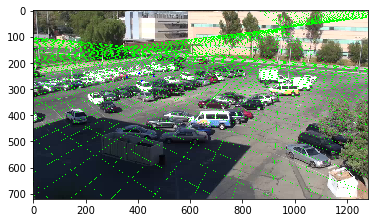

In [5]:
# start position
x, y = -1, -1
points_list = []

# preserve the original image
img = frame0.copy()
param = [points_list]

# set up
cv2.namedWindow('image')
cv2.setMouseCallback('image', point_handler, param)
xrange = (-100, 100)  # drawing parameter
yrange = (-100, 100)  # drawing parameter
H = 0  # the homography

while(1):
    # Keep old image cached
    new_img = img.copy()
    
    # if we have more than 4 points, draw the grid
    if len(param[0]) == 4:
        H = get_homography(param[0])        
        line_img = draw_gridlines(new_img, H, xrange, yrange, step=5)
        new_img = cv2.addWeighted(new_img, 0.9, line_img, 0.1, 0)
    
    # handle drawing
    new_img = draw_points(new_img, param[0])
    cv2.imshow('image', new_img)
    
    key = cv2.waitKey(20)
    if key == 27:  #esc - to get out of loop
        break
    elif key == 32:  # space - help with debugging
        #print('{}, {}'.format(x, y))
        print(len(param[0]))
        
cv2.destroyAllWindows()
print(points_list)
print(H)
plt.imshow(new_img)

### See how it looks in real world coordinates

### Experiment with scaling

In [42]:
# Utilities to convert bounding box stuff into birds eye view coordinates

def image_to_bird(coord, H):
    """ 
    Given coords in the form (xi, yi, 1).T and the image-->bird homography, return the birds eye view coords
    """
    pt_bird = H @ coord
    pt_bird = pt_bird / pt_bird[2]
    return pt_bird

def box_to_image_plane(coord1, coord2, H):
    """
    Coord1 should be a bottom corner, and coord2 should be a top corner.
    """
    pt1 = coord1
    pt2 = np.array([coord2[0], coord1[1], 1])
    
    pt1_bird = image_to_bird(pt1, H)
    pt2_bird = image_to_bird(pt2, H)
    return pt1_bird, pt2_bird

# TODO: see how good circles look

In [43]:
# Random stuff to check out later

def rot_x(theta):
    return np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])

def rot_y(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])

def rot_z(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

def trans_mat(xoffset, yoffset):
    return np.array([[1, 0, xoffset],
                    [0, 1, yoffset],
                    [0, 0, 1]])


Import feet coordinates

In [44]:
import numpy as np
import pickle
from PIL import Image
with open('feet_coord.pkl', 'rb') as f:
    feet=pickle.load(f)

Identify people being too close

In [45]:
H = load_homography('homographies/VIRAT_0101_homography_img2world.txt')
np.linalg.norm(image_to_bird(np.array([[352, 260,1]]).T,H)-image_to_bird(np.array([[437, 277,1]]).T,H))


8.696292230371611

In [91]:
#threshold is set as the distance between [410, 242], and [352, 260]
threshold=np.linalg.norm(image_to_bird(np.array([[352, 260,1]]).T,H)-image_to_bird(np.array([[437, 277,1]]).T,H))
threshold=8
ifclose=[]
for j in range(len(feet)):
    distancetf=[]
    for i in range(len(feet[j])):
        onefoot=np.concatenate((np.array([feet[j][i]]),np.array([[1]])),axis=1).T
        otherfeet=np.concatenate((np.array(feet[j]),np.ones((np.array(feet[j]).shape[0],1))),axis=1).T
        distance=np.sum(abs(np.linalg.norm(image_to_bird(otherfeet,H)-image_to_bird(onefoot,H),axis=0))<threshold)>1
        #print(np.linalg.norm(np.array(feet[j])-np.array(feet[j][i]),axis=1))
        distancetf.append(distance)
    ifclose.append(distancetf)


[[False, False],
 [False],
 [False, False],
 [False],
 [True, True],
 [True, True, False],
 [True, False, False, True],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, True, False, True],
 [False, False, False],
 [True, False, False, True],
 [True, False, False, True],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False],
 [False, False],
 [False, False, False],
 [False, False],
 [False, False],
 [False, False],
 [False, False],
 [False],
 [False],
 [False],
 [False],
 [False, False],
 [False, False, False],
 [False, False, False],
 [False, False, False],
 [False, False],
 [False, False],
 [False, False, False, False],
 [False, False, False],
 [False],
 [False, True, False, True],
 [False, False, False, False],
 [False, False, True, True],
 [False],
 [False, False, False],
 [False, False, False],
 [False],
 [False],
 [False],
 [False, False],
 [False, False],
 [False, False],
 [False, False],
 [

In [68]:
#draw circle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def Circle(coord,radius,color):
   circle=patches.Circle(coord,radius,facecolor=color
          ,linewidth='2.2')
   plt.gca().add_patch(circle)
   

In [92]:
path = 'videos/VIRAT_S_010111_08_000920_000954.mp4'
scale = 1
s = 1
video = v2i(path, scale)
H = load_homography('homographies/VIRAT_0101_homography_img2world.txt')
#im = Image.fromarray(timg)
#cv2.imshow(im)
for j in range(len(feet)):
    frame = next(video)
    timg = cv2.warpPerspective(frame, trans_mat(20, 20) @ H, (100, 150))
    plt.imshow(timg)
    if len(feet[j])!=0: 
        for i in range(len(feet[j])):

            f=np.concatenate((np.array([feet[j][i]]),np.array([[1]])),axis=1).T
            
            pt = get_scaled_coord(f, trans_mat(20, 20) @  H, s)
            if ifclose[j][i]:
                Circle((pt[0], pt[1]), 2,'red')
            else:
                Circle((pt[0], pt[1]), 2,'blue')
            

    plt.savefig('feet_frames/'+str(j)+'.png')
    plt.close()


In [93]:
import cv2
import os

image_folder = 'feet_frames'
video_name = 'test_threshold8.avi'

images=[]
for i in range(len(feet)):
    images.append(str(i)+'.png')

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 20, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
